# Creation of a neural network with Keras for the classification of products from the data set fashion_mnist.

## Imports

In [65]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.datasets import fashion_mnist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import json
from datetime import datetime
from tabulate import tabulate

%matplotlib inline

import os
# macOS specipic workaround for not working GPU on tf v2.16.1
# os.environ['TF_USE_LEGACY_KERAS'] = '1'
# When = 3, the messages (1 - informational(I), 2 - warnings(W) and 3- errors(E)) will not be logged during code execution.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [66]:
print("TensorFlow", tf.__version__)
# Ensure we see the GPU in device list in the macOS.
# print('Visible Devices: ', tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


TensorFlow 2.16.1
GPU details:  {'device_name': 'METAL'}


In [67]:
def plot_model(history=None, model_version='v1'):
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'],
             label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'],
             label='Validation Accuracy', color='green', marker='x')
    plt.plot(history.history['loss'],
             label='Training Loss', color='red', linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss',
             color='goldenrod', linestyle='--', marker='x')
    plt.title(
        f'Model {model_version} - Training and Validation Performance', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy and Loss (Scored Separately)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def save_metrics(loss, accuracy, file_name="model_metrics.json", comment=""):
  data = {"Created_at": datetime.now().isoformat(), "Loss": loss, "Accuracy": accuracy, "Comment": comment}
  try:
    with open(file_name, "r") as f:
      existing_data = json.load(f)
  except FileNotFoundError:
    existing_data = []
  with open(file_name, "w") as f:
    json.dump(existing_data + [data], f, indent=4)



def display_metrics(file_name="model_metrics.json"):
  try:
    with open(file_name, "r") as f:
      metrics_data = json.load(f)
  except FileNotFoundError:
    print("No metrics file found.")
    return

  if not all(key in entry for entry in metrics_data for key in ["Loss", "Accuracy", "Comment"]):
    print("Warning: Some entries in the metrics file might be missing required keys.")

  headers = ["Loss", "Accuracy", "Comment"]
  rows = [[entry.get("Loss"), entry.get("Accuracy"), entry.get("Comment")] for entry in metrics_data]
  print(tabulate(rows, headers=headers, tablefmt="pretty"))


## Load data

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28 * 28) / 255
X_test = X_test.reshape(X_test.shape[0], 28 * 28) / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Multi Layer Regular Neural Net

In [6]:
model_v12 = Sequential(name='v12')
model_v12.add(Dense(256, activation='tanh', input_shape=(784,), name='v12_hidden1'))
model_v12.add(Dropout(0.2, name='v12_hidden2'))
model_v12.add(Dense(128, activation='tanh', name='v12_hidden3'))
model_v12.add(Dense(10, activation='softmax', name='v12_output'))

model_v12.compile(
    optimizer=Adam(learning_rate=0.0005), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

model_v12.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "v12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ v12_hidden1 (Dense)             │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v12_hidden2 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v12_hidden3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ v12_output (Dense)              │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
%%time
history_model_v12 = model_v12.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)



Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7698 - loss: 0.6625 - val_accuracy: 0.8516 - val_loss: 0.4104 - learning_rate: 5.0000e-04
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8484 - loss: 0.4121 - val_accuracy: 0.8618 - val_loss: 0.3771 - learning_rate: 5.0000e-04
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8626 - loss: 0.3728 - val_accuracy: 0.8683 - val_loss: 0.3666 - learning_rate: 5.0000e-04
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8751 - loss: 0.3429 - val_accuracy: 0.8608 - val_loss: 0.3727 - learning_rate: 5.0000e-04
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8789 - loss: 0.3228 - val_accuracy: 0.8741 - val_loss: 0.3411 - learning_rate: 5.0000e-04
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8871 - loss: 0.3073 - val_accuracy: 0.8796 - val_loss: 0.3349 - learning_rate: 5.0000e-04
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/ste

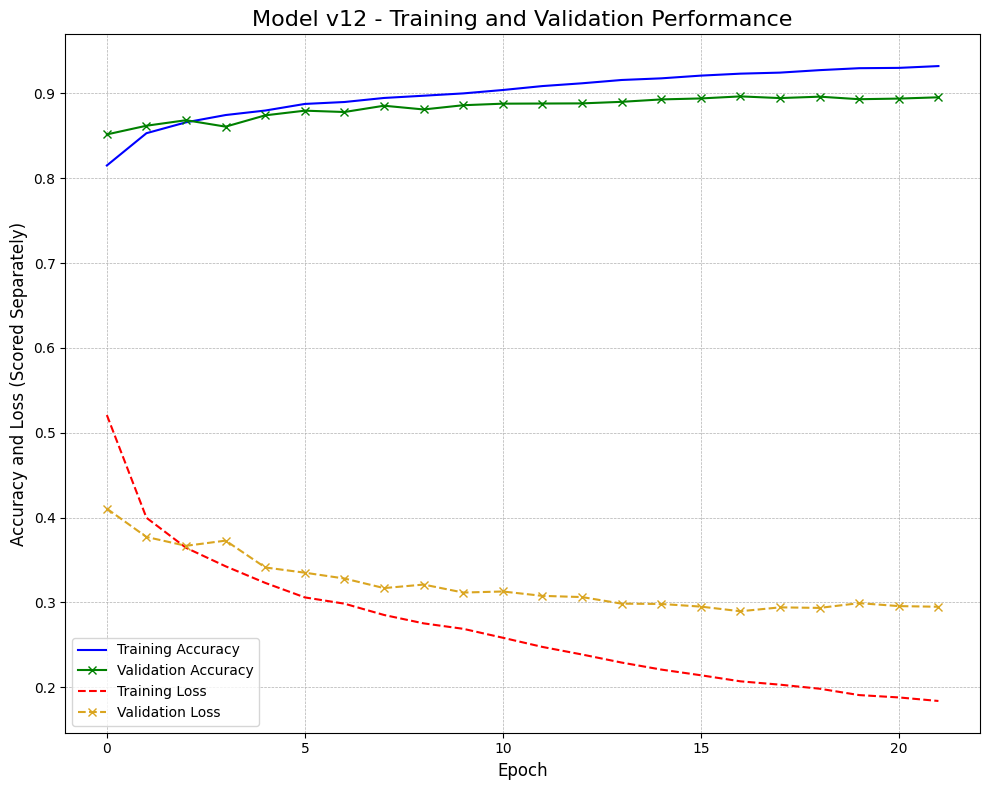

In [8]:
plot_model(history_model_v12, model_version='v12')

In [9]:
# Evaluate the model
test_loss, test_acc = model_v12.evaluate(X_test, y_test, verbose=1)
save_metrics(loss=test_loss, accuracy=test_acc, file_name='model_metrics.json', comment='multilayer regular neural net')
print(f'\nTest accuracy: {test_acc} Test loss: {test_loss}')
display_metrics(file_name='model_metrics.json')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.8925 - loss: 0.3098

Test accuracy: 0.8910999894142151 Test loss: 0.3100658655166626
+--------------------+--------------------+------------------------------+
|        Loss        |      Accuracy      |           Comment            |
+--------------------+--------------------+------------------------------+
| 0.3100658655166626 | 0.8910999894142151 | mulilayer regular neural net |
+--------------------+--------------------+------------------------------+


### Model v12 Summary


* Accuracy on the train data is above `0.91`. Test Accuracy is `0.8911` and this is below `0.91`




## Conv2D v1

In [10]:
# Load and preprocess the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0


# Add a channels dimension
x_train = X_train[..., tf.newaxis]
x_test = X_test[..., tf.newaxis]


In [11]:
# Define the model architecture v1

model_conv2d_v1 = Sequential(name='conv2d_v1')
model_conv2d_v1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), name='conv2d_layer1'))
model_conv2d_v1.add(MaxPooling2D((2, 2), name='maxpool_layer1'))
model_conv2d_v1.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_layer2'))
model_conv2d_v1.add(MaxPooling2D((2, 2), name='maxpool_layer2'))
model_conv2d_v1.add(Conv2D(64, (3, 3), activation='relu', name='conv2d_layer3'))
model_conv2d_v1.add(Flatten(name='flatten_layer'))
model_conv2d_v1.add(Dense(64, activation='relu', name='dense_layer1'))
model_conv2d_v1.add(Dense(10, activation='softmax', name='output_layer'))

# Compile the model
model_conv2d_v1.compile(optimizer=Adam(learning_rate=0.0005),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        # return lr * tf.math.exp(-0.1)
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Print the model summary
model_conv2d_v1.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "conv2d_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer1 (Conv2D)          │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer2 (Conv2D)          │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer2 (MaxPooling2D)   │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer3 (Conv2D)          │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer1 (Dense)            │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
%%time
# Train the model

history_model_conv2d_v1=model_conv2d_v1.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=25,
    validation_split=0.2,
    validation_data=(X_test, y_test),
    #callbacks=[early_stopping, lr_scheduler]
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6537 - loss: 1.0275 - val_accuracy: 0.8165 - val_loss: 0.5021 - learning_rate: 5.0000e-04
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8370 - loss: 0.4503 - val_accuracy: 0.8575 - val_loss: 0.4006 - learning_rate: 5.0000e-04
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8676 - loss: 0.3775 - val_accuracy: 0.8613 - val_loss: 0.3795 - learning_rate: 5.0000e-04
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.8796 - loss: 0.3345 - val_accuracy: 0.8776 - val_loss: 0.3453 - learning_rate: 5.0000e-04
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8890 - loss: 0.3075 - val_accuracy: 0.8847 - val_loss: 0.3251 - learning_rate: 5.0000e-04
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8950 - loss: 0.2908 - val_accuracy: 0.8849 - val_loss: 0.3095 - learning_rate: 5.0000e-04
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/ste

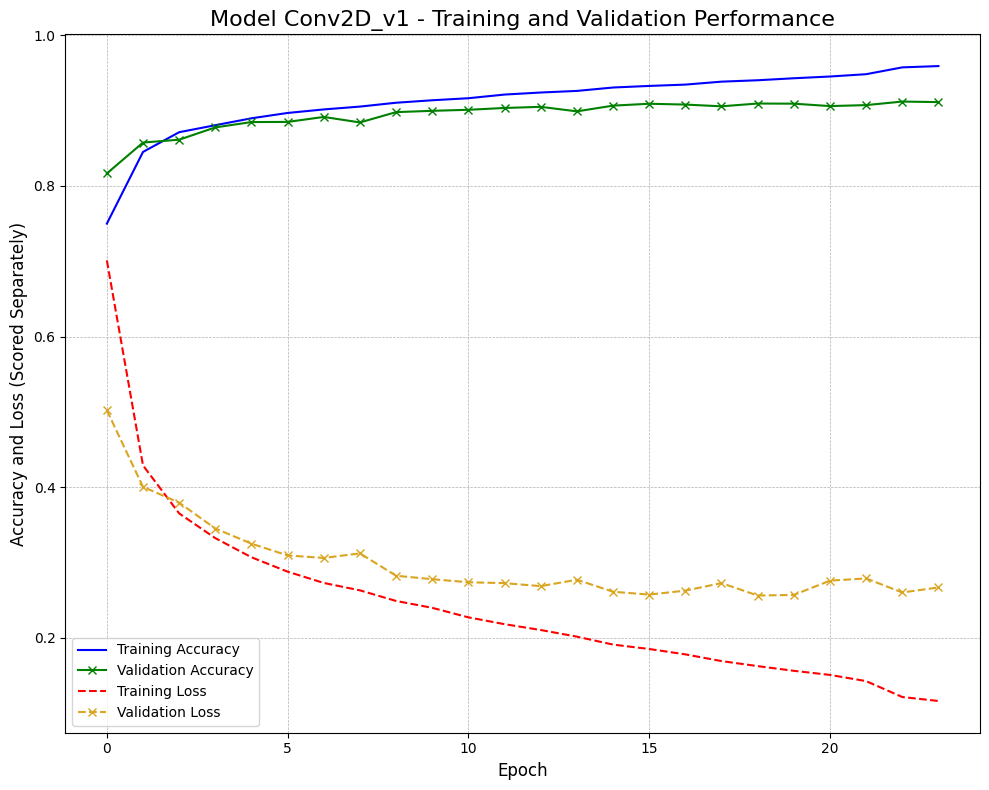

In [13]:
plot_model(history_model_conv2d_v1, model_version='Conv2D_v1')

In [14]:
# Evaluate the model
test_loss, test_acc = model_conv2d_v1.evaluate(X_test, y_test, verbose=2)
save_metrics(loss=test_loss, accuracy=test_acc, file_name='model_metrics.json', comment='Conv2D_v1 neural net')
print(f'\nTest accuracy: {test_acc} Test loss: {test_loss}')
display_metrics(file_name='model_metrics.json')

313/313 - 1s - 3ms/step - accuracy: 0.9093 - loss: 0.2563

Test accuracy: 0.9093000292778015 Test loss: 0.25632619857788086
+---------------------+--------------------+------------------------------+
|        Loss         |      Accuracy      |           Comment            |
+---------------------+--------------------+------------------------------+
| 0.3100658655166626  | 0.8910999894142151 | mulilayer regular neural net |
| 0.25632619857788086 | 0.9093000292778015 |     Conv2D_v1 neural net     |
+---------------------+--------------------+------------------------------+


### Model Conv2D_v1 

* Conv2D_v1 achieves an accuracy of `0.9093`, indicating it nearly reaches the target accuracy `0.91`.
* Training time: `4min 27s`

## Conv2D v2

In [15]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Define the model architecture
model_conv2d_v2 = models.Sequential(name='conv2d_v2')
model_conv2d_v2.add(layers.Input(shape=(28, 28, 1), name='input_layer'))
#model_conv2d.add(data_augmentation)

model_conv2d_v2.add(layers.Conv2D(32, (3, 3), activation='relu', name='conv2d_layer1'))
model_conv2d_v2.add(layers.BatchNormalization(name='batchnorm_layer1'))
model_conv2d_v2.add(layers.MaxPooling2D((2, 2), name='maxpool_layer1'))
model_conv2d_v2.add(layers.Dropout(0.3, name='dropout_layer1'))

#model_conv2d_v2.add(layers.Conv2D(64, (3, 3), activation='relu', name='conv2d_layer2'))
#model_conv2d_v2.add(layers.BatchNormalization(name='batchnorm_layer2'))
#model_conv2d_v2.add(layers.MaxPooling2D((2, 2), name='maxpool_layer2'))
#model_conv2d_v2.add(layers.Dropout(0.3, name='dropout_layer2'))
#model_conv2d_v2.add(Flatten(name='flatten_layer'))
#model_conv2d_v2.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv2d_layer3'))
#model_conv2d_v2.add(layers.BatchNormalization(name='batchnorm_layer3'))
#model_conv2d_v2.add(layers.MaxPooling2D((2, 2), name='maxpool_layer3'))
model_conv2d_v2.add(layers.Dropout(0.3, name='dropout_layer3'))

model_conv2d_v2.add(layers.Flatten(name='flatten_layer'))

model_conv2d_v2.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='dense_layer1'))
model_conv2d_v2.add(layers.BatchNormalization(name='batchnorm_dense1'))
model_conv2d_v2.add(layers.Dropout(0.5, name='dropout_dense1'))

model_conv2d_v2.add(layers.Dense(10, activation='softmax', name='output_layer'))

# Compile the model
model_conv2d_v2.compile(optimizer=Adam(learning_rate=0.0005),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        # return lr * tf.math.exp(-0.1)
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

# Print the model summary
model_conv2d_v2.summary()



Model: "conv2d_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer1 (Conv2D)          │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_layer1                │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer1 (MaxPooling2D)   │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer1 (Dropout)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer3 (Dropout)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer1 (Dense)            │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_dense1                │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense1 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,602 (2.65 MB)

 Trainable params: 694,282 (2.65 MB)

 Non-trainable params: 320 (1.25 KB)

In [16]:
%%time
# Train the model
history_model_conv2d_v2 = model_conv2d_v2.fit(
    x_train, 
    y_train, 
    batch_size=128,
    epochs=70,
    #validation_split=0.2,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.7387 - loss: 1.0434 - val_accuracy: 0.8331 - val_loss: 0.7893 - learning_rate: 5.0000e-04
Epoch 2/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8592 - loss: 0.6025 - val_accuracy: 0.8857 - val_loss: 0.4881 - learning_rate: 5.0000e-04
Epoch 3/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8754 - loss: 0.5160 - val_accuracy: 0.8911 - val_loss: 0.4535 - learning_rate: 5.0000e-04
Epoch 4/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8837 - loss: 0.4680 - val_accuracy: 0.8930 - val_loss: 0.4267 - learning_rate: 5.0000e-04
Epoch 5/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8872 - loss: 0.4485 - val_accuracy: 0.8878 - val_loss: 0.4340 - learning_rate: 5.0000e-04
Epoch 6/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8915 - loss: 0.4270 - val_accuracy: 0.8940 - val_loss: 0.4121 - learning_rate: 5.0000e-04
Epoch 7/70
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/ste

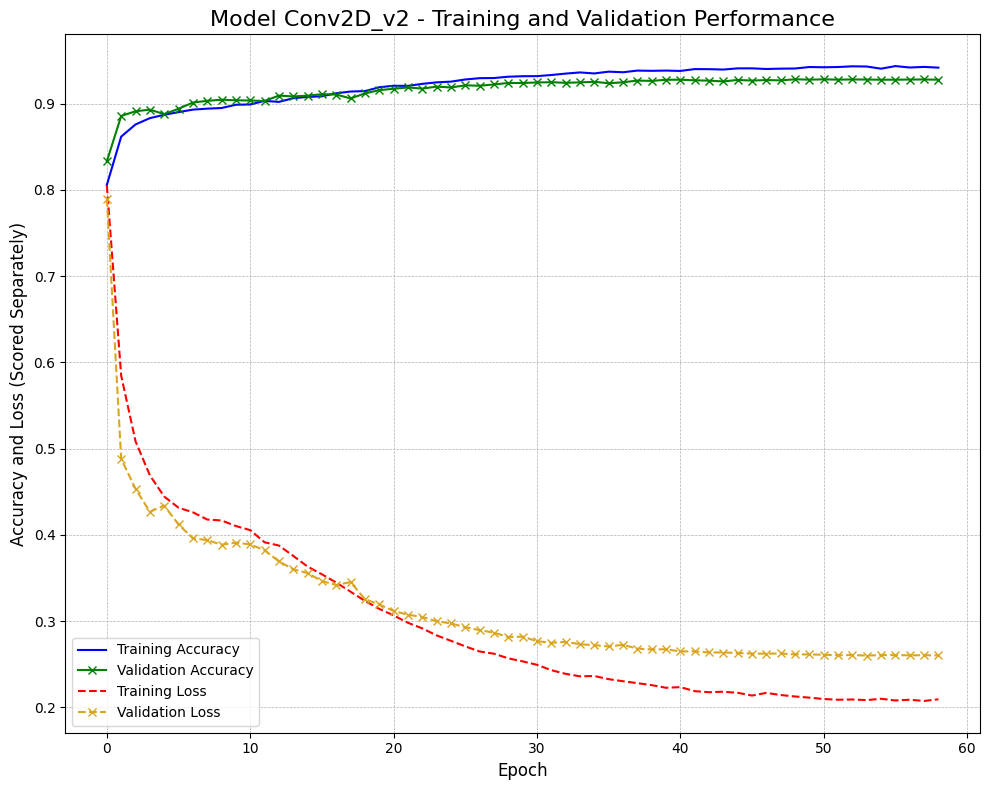

In [17]:
plot_model(history_model_conv2d_v2, model_version='Conv2D_v2')

In [24]:
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

# Evaluate the model
test_loss, test_acc = model_conv2d_v2.evaluate(X_test, y_test, verbose=1)
save_metrics(loss=test_loss, accuracy=test_acc, file_name='model_metrics.json', comment='Conv2D_v2 improved Conv2D_v1 model')
print(f'\nTest accuracy: {test_acc} Test loss: {test_loss}')
display_metrics(file_name='model_metrics.json')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9271 - loss: 0.2623

Test accuracy: 0.9279000163078308 Test loss: 0.26006075739860535
+---------------------+--------------------+------------------------------------+
|        Loss         |      Accuracy      |              Comment               |
+---------------------+--------------------+------------------------------------+
| 0.3100658655166626  | 0.8910999894142151 |    mulilayer regular neural net    |
| 0.25632619857788086 | 0.9093000292778015 |        Conv2D_v1 neural net        |
| 0.26006075739860535 | 0.9279000163078308 | Conv2D_v2 improved Conv2D_v1 model |
+---------------------+--------------------+------------------------------------+


### Conv2D v2 Summary

**Changes:** Modified architecture.

**Training Time:** Slower than Conv2D v1 (`14min 7s` vs. `4min 27s`).


**Key points**
* Conv2D_v2 achieves an accuracy of `0.9279`, which is `0.0186` higher than Conv2D_v1.

* Even though Conv2D v2 achieves a higher accuracy than Conv2D v1, it also takes longer to train than Conv2D_v1. 

## VGG16 v2

In [68]:
# Load and preprocess the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

# Add a channels dimension and resize to 32x32
X_train = tf.image.resize(X_train[..., tf.newaxis], [32, 32])
X_test = tf.image.resize(X_test[..., tf.newaxis], [32, 32])

# Convert grayscale images to RGB by duplicating channels
X_train = tf.image.grayscale_to_rgb(X_train)
X_test = tf.image.grayscale_to_rgb(X_test)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



# Define data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     fill_mode="nearest"
# )
# datagen.fit(X_train)


In [69]:
# Load the VGG16 model, without the top layers, with weights pre-trained on ImageNet
base_model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Unfreeze the last few layers of the VGG16 model
# for layer in base_model.layers[-4:]:
#     layer.trainable = True

# Create a new model using VGG16 as the base
model_vgg16_v2 = Sequential(name='vgg16_net_v2')
model_vgg16_v2.add(base_model)
model_vgg16_v2.add(Flatten(name='flatten_layer'))
model_vgg16_v2.add(Dense(256, activation='relu', name='dense_layer1'))
model_vgg16_v2.add(BatchNormalization(name='batchnorm_layer1'))
model_vgg16_v2.add(Dropout(0.25, name='dropout_layer1'))
#-model_vgg16_v2.add(Dense(64, activation='relu', name='dense_layer2'))
#-model_vgg16_v2.add(BatchNormalization(name='batchnorm_layer2'))
#-model_vgg16_v2.add(Dropout(0.5, name='dropout_layer2'))
model_vgg16_v2.add(Dense(10, activation='softmax', name='output_layer'))

# Compile the model
initial_learning_rate = 0.001
model_vgg16_v2.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                       #loss='sparse_categorical_crossentropy',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Define early stopping, learning rate reduction, and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg16_fashion_mnist.keras', save_best_only=True, monitor='val_loss')

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)



In [70]:
%%time
# Train the model
model_history_vgg16_v2 = model_vgg16_v2.fit(X_train, y_train, batch_size=128,
                                      #steps_per_epoch=50,
                                      epochs=50,
                                      validation_data=(X_test, y_test),
                                      #callbacks=[])
                                      callbacks=[early_stopping, reduce_lr, lr_scheduler, checkpoint])

# Test accuracy: 0.8770999908447266 Test loss: 0.34798315167427063 all layers
# Test accuracy: 0.8784999847412109 Test loss: 0.34821221232414246 -3 layers (dense_layer2, batchnorm_layer2, dropout_layer2)
# Test accuracy: 0.8769000172615051 Test loss: 0.34962213039398193 -3 layers (dropout_layer1, batchnorm_layer2,)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.7523 - loss: 0.7215 - val_accuracy: 0.8373 - val_loss: 0.4490 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.8447 - loss: 0.4335 - val_accuracy: 0.8537 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 78ms/step - accuracy: 0.8560 - loss: 0.3932 - val_accuracy: 0.8449 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 83ms/step - accuracy: 0.8638 - loss: 0.3706 - val_accuracy: 0.8562 - val_loss: 0.3967 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.8639 - loss: 0.3673 - val_accuracy: 0.8573 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.8681 - loss: 0.3603 - val_accuracy: 0.8614 - val_loss: 0.3845 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.8678 - l

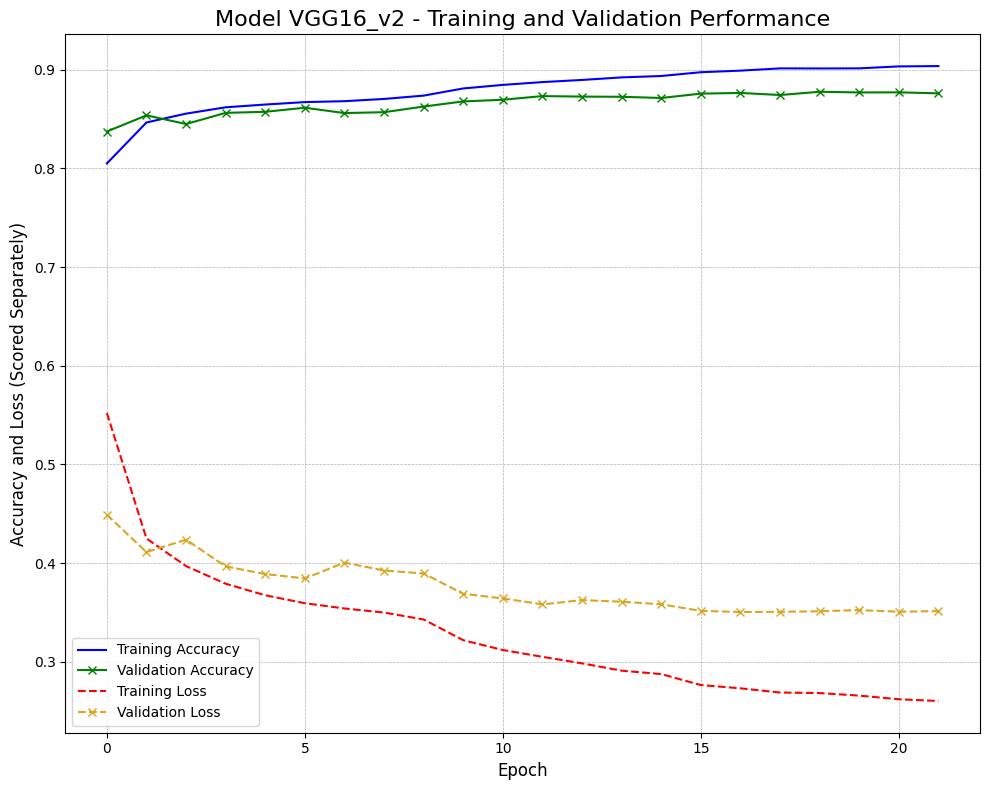

In [71]:
plot_model(model_history_vgg16_v2 , model_version='VGG16_v2')

In [72]:
# Evaluate the model
test_loss, test_acc = model_vgg16_v2.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_acc} Test loss: {test_loss}')
save_metrics(loss=test_loss, accuracy=test_acc, file_name='model_metrics.json', comment='VGG16_v2 neural net')
display_metrics(file_name='model_metrics.json')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8776 - loss: 0.3427

Test accuracy: 0.8763999938964844 Test loss: 0.35051268339157104
+---------------------+--------------------+------------------------------------+
|        Loss         |      Accuracy      |              Comment               |
+---------------------+--------------------+------------------------------------+
| 0.3100658655166626  | 0.8910999894142151 |    mulilayer regular neural net    |
| 0.25632619857788086 | 0.9093000292778015 |        Conv2D_v1 neural net        |
| 0.26006075739860535 | 0.9279000163078308 | Conv2D_v2 improved Conv2D_v1 model |
| 0.35051268339157104 | 0.8763999938964844 |        VGG16_v2 neural net         |
+---------------------+--------------------+------------------------------------+


### VGG16_v2 Summary

**Based on:** VGG16

**Training Hardware:** GPU (15min 25s)

**Training Time:** Approximately

* 2.5x slower on TPU.
* 15x slower on CPU.

**Key points**

* VGG16_v2 achieves an accuracy of `0.8764,` which is `0.0515` lower than Conv2D_v2.
* VGG16_v2 take significantly longer to train on TPU or CPU hardware.


## Continue Learning (fine-tuning)

In [85]:
# Load the saved model
model_vgg16_v2 = tf.keras.models.load_model('vgg16_fashion_mnist.keras')

# Define data augmentation
# bad result: Test accuracy: 0.8673999905586243 Test loss: 0.3884202539920807
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen.fit(X_train)

# Unfreeze the last few layers of the VGG16 model
# for layer in model_vgg16_v2.layers[0].layers[-4:]:
for layer in base_model.layers[-8:]:
    # Unfreeze the last few layers of the VGG16 model
    layer.trainable = True

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Recompile the model with a lower learning rate for fine-tuning
fine_tune_learning_rate = 1e-5
model_vgg16_v2.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])



In [86]:
%%time
# Train the model further with data augmentation
model_history_vgg16_v2_ft = model_vgg16_v2.fit(X_train, y_train, batch_size=128,
                                               epochs=50,
                                               validation_data=(X_test, y_test),
                                               callbacks=[early_stopping, reduce_lr, lr_scheduler])

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.9037 - loss: 0.2662 - val_accuracy: 0.8761 - val_loss: 0.3502 - learning_rate: 1.0000e-05
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.8987 - loss: 0.2697 - val_accuracy: 0.8768 - val_loss: 0.3502 - learning_rate: 1.0000e-05
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 90ms/step - accuracy: 0.9020 - loss: 0.2678 - val_accuracy: 0.8760 - val_loss: 0.3504 - learning_rate: 1.0000e-05
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9024 - loss: 0.2668 - val_accuracy: 0.8765 - val_loss: 0.3503 - learning_rate: 5.0000e-06
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9059 - loss: 0.2574 - val_accuracy: 0.8761 - val_loss: 0.3503 - learning_rate: 5.0000e-06
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.9015 - loss: 0.2643 - val_accuracy: 0.8765 - val_loss: 0.3503 - learning_rate: 5.0000e-06
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/ste

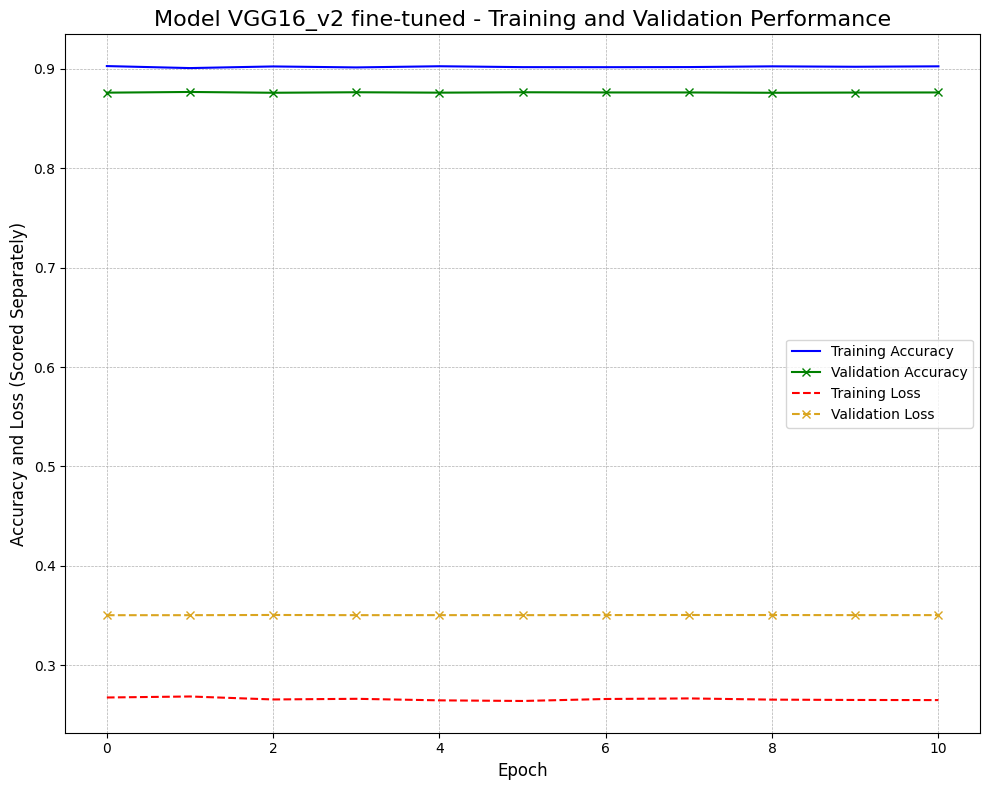

In [87]:
plot_model(model_history_vgg16_v2_ft, model_version='VGG16_v2 fine-tuned')

In [89]:
# Evaluate the model
test_loss, test_acc = model_vgg16_v2.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_acc} Test loss: {test_loss}')
save_metrics(loss=test_loss, accuracy=test_acc, file_name='model_metrics.json', comment='VGG16_v2 fine-tuned')
display_metrics(file_name='model_metrics.json')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8785 - loss: 0.3424

Test accuracy: 0.8761000037193298 Test loss: 0.35021787881851196
+---------------------+--------------------+------------------------------------+
|        Loss         |      Accuracy      |              Comment               |
+---------------------+--------------------+------------------------------------+
| 0.3100658655166626  | 0.8910999894142151 |    mulilayer regular neural net    |
| 0.25632619857788086 | 0.9093000292778015 |        Conv2D_v1 neural net        |
| 0.26006075739860535 | 0.9279000163078308 | Conv2D_v2 improved Conv2D_v1 model |
| 0.35051268339157104 | 0.8763999938964844 |        VGG16_v2 neural net         |
| 0.35021787881851196 | 0.8761000037193298 |        VGG16_v2 fine-tuned         |
+---------------------+--------------------+------------------------------------+


### VGG16_v2 Fine-tuned Summary

**Fine-Tuning Experiments:**

* Data augmentation: No improvement.
* Unfreezing last layers (4 or 8): No significant accuracy change compared to VGG16_v2.
* Lower learning rate: No significant accuracy change compared to VGG16_v2.
* Different batch sizes and epochs explored.

**Results:**

* Test accuracy: `0.8761` (almost identical to VGG16_v2).
* Test loss: `0.3502`.

**Conclusion:**

Fine-tuning VGG16_v2 with the explored techniques did not lead to better performance in this case. 


## Summary of Model Performance for Fashion MNIST Classification

This table compares the accuracy and training time of various neural network models for the Fashion MNIST classification task:

| Model | Accuracy | Training Time | Hardware | Comment |
|---|---|---|---|---|
| Multilayer Regular Neural Net | 0.8911 | 51.1 s | - | Baseline model |
| Conv2D_v1 | 0.9093 | 4min 27s | - | Good accuracy, fast training |
| Conv2D_v2 | `0.9279` | 14min 7s | - | Highest accuracy, slower training than Conv2D_v1 |
| VGG16_v2 | 0.8764 | 15min 25s (GPU) | GPU | Lower accuracy than Conv2D_v2, much slower on CPU/TPU |
| VGG16_v2 Fine-tuned | 0.8761 | - | GPU | No significant improvement over VGG16_v2 |

**Conclusions:**

* Convolutional Neural Networks (CNNs) like Conv2D_v1 and Conv2D_v2 outperform VGG16_v2 for this task.
* Conv2D_v2 achieves the highest accuracy (`0.9279`) but takes longer to train (`14min 7s`) compared to Conv2D_v1 (`4min 27s`).
* Conv2D_v1 offers a good balance between accuracy (`0.9093`) and training speed, making it a strong choice when considering both factors.
* VGG16_v2, while a powerful architecture, underperforms compared to Conv2D models in this specific case. Fine-tuning techniques explored here did not yield significant improvements.
* For fast training of VGG16-based models, a GPU is highly recommended. Training on a TPU may be faster than CPU but still slower than GPU.

**Recommendations:**

* If high accuracy is the top priority and training time allows, Conv2D_v2 is a good choice.
* If a balance between accuracy and training speed is important, Conv2D_v1 is an excellent option, especially when considering training time constraints.
* Utilizing a GPU is crucial for faster training with VGG16-based models.
